In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile as zf
import os
import random
import cv2
import imutils

from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from skimage import feature

from keras.utils import to_categorical
from imutils import build_montages,paths


In [22]:
import os
wave_train_healthy = os.listdir(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\training\healthy")
wave_train_park = os.listdir(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\training\parkinson")

fp_wave_train_healthy = r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\training\healthy"
fp_wave_train_park = r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\training\parkinson"

wave_test_healthy = os.listdir(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\testing\healthy")
wave_test_park = os.listdir(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\testing\parkinson")

fp_wave_test_healthy = r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\testing\healthy"
fp_wave_test_park = r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\testing\parkinson"

In [4]:
from skimage import io, color, exposure, transform, feature

def quantify_image1(image_path):
    # Load the image
    image = io.imread(image_path)
    if image.shape[2] == 4:
        image = image[:, :, :3]  # Keep only the first three channels (RGB)
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)
    
    # Resize the image to a fixed size
    resized_image = transform.resize(gray_image, (200, 200))
    
    # Apply Histogram Equalization to enhance contrast
    equalized_image = exposure.equalize_hist(resized_image)
    
    # Compute HOG features for the preprocessed image
    hog_features = feature.hog(equalized_image, orientations=9,
                               pixels_per_cell=(10, 10),
                               cells_per_block=(2, 2),
                               transform_sqrt=True,
                               block_norm="L1")
    
    return hog_features


In [4]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from sklearn.model_selection import train_test_split
import pywt
def quantify_image(images):
          
            features = []
                # HOG features
            hog_features = hog(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            
            # LBP features
            lbp = local_binary_pattern(images, 8, 1, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9), density=True)
            
            # Gabor features
            frequency = 0.4
            thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            gabor_features = []
            for theta in thetas:
                gabor_real, gabor_imaginary = np.real(gabor_kernel(frequency, theta=theta)), np.imag(gabor_kernel(frequency, theta=theta))
                gabor_features.append(np.mean(ndi.convolve(images, gabor_real)))
                gabor_features.append(np.mean(ndi.convolve(images, gabor_imaginary)))
            
            # DWT coefficients
            coeffs = pywt.dwt2(images, 'haar')
            cA, (cH, cV, cD) = coeffs
            dwt_features = np.concatenate((cA.ravel(), cH.ravel(), cV.ravel(), cD.ravel()))
            
            # Concatenate all features
            all_features = np.concatenate((hog_features, lbp_hist, gabor_features, dwt_features))
            features.append(all_features)
            return features

In [5]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []


testX = []
testY = []




for i in wave_train_healthy:
      # print(i)
      # print(fp_wave_train_healthy+"\\"+i)
      image = cv2.imread(fp_wave_train_healthy+"\\"+i)
      # print(image)
      image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
      image = cv2.resize(image , (200,200))
      image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
      features = quantify_image1(fp_wave_train_healthy+"\\"+i)
      trainX.append(features)
      trainY.append('healthy')

for i in wave_train_park:
  image = cv2.imread(fp_wave_train_park+"\\"+i)
  image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image , (200,200))
  image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  features = quantify_image1(fp_wave_train_park+"\\"+i)
  trainX.append(features)
  trainY.append('parkinson')

for i in wave_test_healthy:
  image = cv2.imread(fp_wave_test_healthy+"\\"+i)
  outputs.append(image)
  image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image , (200,200))
  image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  features = quantify_image1(fp_wave_test_healthy+"\\"+i)
  testX.append(features)
  testY.append('healthy')

for i in wave_test_park:
  image = cv2.imread(fp_wave_test_park+"\\"+i)
  outputs.append(image)
  image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image , (200,200))
  image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  features = quantify_image1(fp_wave_test_park+"\\"+i)
  testX.append(features)
  testY.append('parkinson')


In [6]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

In [7]:
trainX=trainX.reshape(len(trainX),-1)
testX=testX.reshape(len(testX),-1)

In [8]:
trainX.ndim

2

In [9]:
testX.ndim

2

In [10]:
# x.ndim

In [11]:
trainX

array([[0.0204873 , 0.00489638, 0.00370405, ..., 0.0149996 , 0.00759837,
        0.00943321],
       [0.02407258, 0.01008212, 0.0057483 , ..., 0.02038246, 0.03116981,
        0.02024233],
       [0.01984089, 0.02485808, 0.02172769, ..., 0.02762435, 0.02439034,
        0.03181525],
       ...,
       [0.02157298, 0.01799953, 0.02586592, ..., 0.01059433, 0.01714045,
        0.02970032],
       [0.04528283, 0.02653013, 0.0132581 , ..., 0.04169707, 0.0214954 ,
        0.02193564],
       [0.02887707, 0.00727548, 0.00565702, ..., 0.02627986, 0.03534224,
        0.01822088]])

In [12]:
testX

array([[0.02069794, 0.0123157 , 0.00438472, ..., 0.02904596, 0.05029355,
        0.04489851],
       [0.02534537, 0.01183601, 0.00126338, ..., 0.0335792 , 0.03263905,
        0.02519485],
       [0.02269139, 0.00969476, 0.01910089, ..., 0.02727517, 0.01952617,
        0.0117635 ],
       ...,
       [0.04049971, 0.00861438, 0.00371261, ..., 0.04978104, 0.0406956 ,
        0.031145  ],
       [0.02484401, 0.00617357, 0.00390237, ..., 0.01548625, 0.02244642,
        0.02045226],
       [0.03743444, 0.01520355, 0.03368335, ..., 0.03486086, 0.02494201,
        0.01751793]])

In [13]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson'], dtype='<U9')

In [14]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson'], dtype='<U9')

In [15]:
le = LabelEncoder()

In [16]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [17]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [18]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
#model = RandomForestClassifier(n_estimators=100)
#model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier()

In [20]:
knn_model.fit(trainX,trainY)

KNeighborsClassifier()

In [21]:
preds = knn_model.predict(testX)
preds

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

In [22]:
cnf = confusion_matrix(testY,preds)
cnf

array([[12,  3],
       [ 2, 13]], dtype=int64)

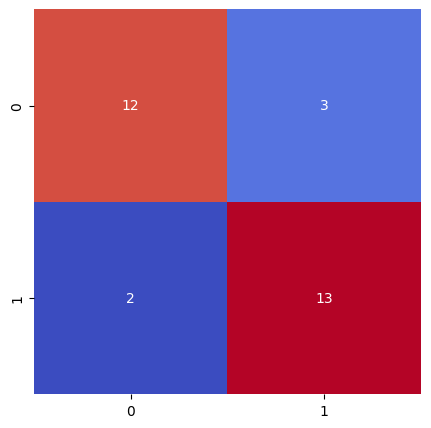

In [23]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [24]:
knn_acc = metrics.accuracy_score(testY,preds)
knn_acc

0.8333333333333334

<b> Random Forest </b>


In [25]:
model = RandomForestClassifier(n_estimators=100)
model.fit(trainX,trainY)
#model = LogisticRegression(max_iter=1000)

RandomForestClassifier()

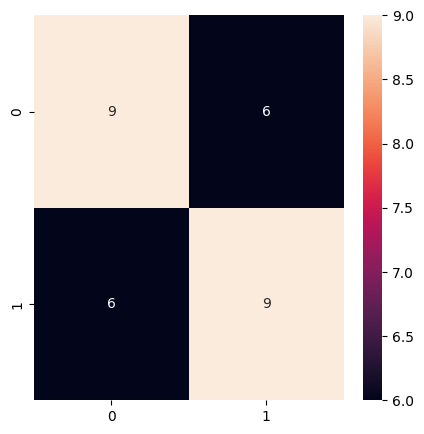

In [26]:
preds = model.predict(testX)
cm=confusion_matrix(testY,preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.show()

In [27]:
random_acc = metrics.accuracy_score(testY,preds)
random_acc

0.6

<b> Logistic Regression</b>

In [28]:
model = LogisticRegression(max_iter=1000)
model.fit(trainX,trainY)

LogisticRegression(max_iter=1000)

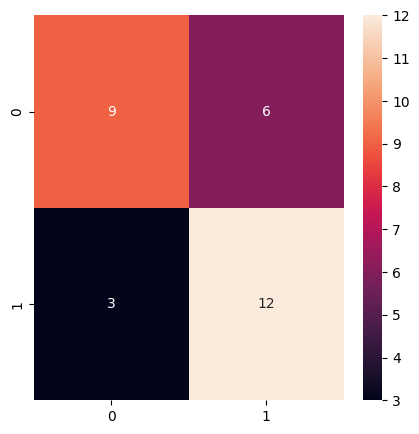

In [29]:
preds = model.predict(testX)
cm=confusion_matrix(testY,preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.show()

In [30]:
lr_acc = metrics.accuracy_score(testY,preds)
lr_acc

0.7

<b> Gradient Boosting Classifier</b>

In [31]:
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.metrics import accuracy_score
gb_classifier = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gb_classifier.fit(trainX, trainY)
gb_predictions = gb_classifier.predict(testX)
gb_accuracy = accuracy_score(testY, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

Gradient Boosting Accuracy: 0.6666666666666666


In [32]:
# Gradient Boosting Classifier
gb_conf_matrix = confusion_matrix(testY, gb_predictions)
gb_class_report = classification_report(testY, gb_predictions)

In [33]:
accuracy_scores = {
    'Model': ['Random Forest', 'Gradient Boosting', 'KNeighborsClassifier', 'Logistic Regression'],
    'Accuracy': [random_acc, gb_accuracy, knn_acc, lr_acc]
}


In [34]:
accuracy_df = pd.DataFrame(accuracy_scores,index=['a','b','c','d'])

# Display the DataFrame
print(accuracy_df)

                  Model  Accuracy
a         Random Forest  0.600000
b     Gradient Boosting  0.666667
c  KNeighborsClassifier  0.833333
d   Logistic Regression  0.700000


In [35]:
accuracy_df

,Model,Accuracy
a,Random Forest,0.600000
b,Gradient Boosting,0.666667
c,KNeighborsClassifier,0.833333
d,Logistic Regression,0.700000


In [36]:
import pickle
with open('KNN_Wave.pickle','wb')as file:
    pickle.dump(knn_model,file)

In [3]:
import pickle
Wave_model = pickle.load(open("KNN_Wave.pickle",'rb'))

In [ ]:
No such file: 'C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Models\"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\training\healthy\V07HO02.png"

In [12]:
import cv2
image = cv2.imread(r'Datasets/wave/training/parkinson/V02PO02.png')
# print(image)
# image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image , (200,200))
# image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
features = quantify_image1(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\training\healthy\V07HO02.png")

In [17]:
features = quantify_image1(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\training\parkinson\V09PO02.png")
Wave_model.predict([features])

array([1], dtype=int64)

In [18]:
features = quantify_image1(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\training\parkinson\V06PO03.png")
Wave_model.predict([features])

array([1], dtype=int64)

In [19]:
features = quantify_image1(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\testing\healthy\V04HO01.png")
Wave_model.predict([features])

array([1], dtype=int64)

In [26]:
features=quantify_image1(r"C:\Users\shiha\OneDrive\Desktop\playground\parkinson_musiliar_college\Datasets\wave\testing\healthy\V01HO01.png")
Wave_model.predict([features])

array([0], dtype=int64)

In [25]:
for i in wave_test_healthy:
   features = quantify_image1(fp_wave_test_healthy+"\\"+i)
   print(Wave_model.predict([features]))

[0]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [27]:
for i in wave_test_park:
   features = quantify_image1(fp_wave_test_park+"\\"+i)
   print(Wave_model.predict([features]))

[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
